In [48]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV, Ridge
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [49]:
filename_one = './homework_data/yellow_tripdata_2023-01.parquet'
filename_two = './homework_data/yellow_tripdata_2023-02.parquet'
df_one = pd.read_parquet(filename_one)
df_two = pd.read_parquet(filename_two)

Download the data for January and February 2023.
1. Read the data for January. How many columns are there?

In [50]:
print("Length of columns: ", len(df_one.columns))

Length of columns:  19


In [51]:
df_one.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


2. Now let's compute the duration variable. It should contain the duration of a ride in minutes.<br>
What's the standard deviation of the trips duration in January?

In [52]:
df_one['duration'] = df_one.tpep_dropoff_datetime - df_one.tpep_pickup_datetime
df_one.duration = df_one.duration.apply(lambda td: td.total_seconds() / 60)
print("Standard deviation of trips duration in January", np.std(df_one.duration))

Standard deviation of trips duration in January 42.59434429744777


In [53]:
df_one.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


3. Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).
What fraction of the records left after you dropped the outliers?

Original data count:  3066766
Filtered data count:  3009173
Fraction of records remaining after removing outliers: 98.12%


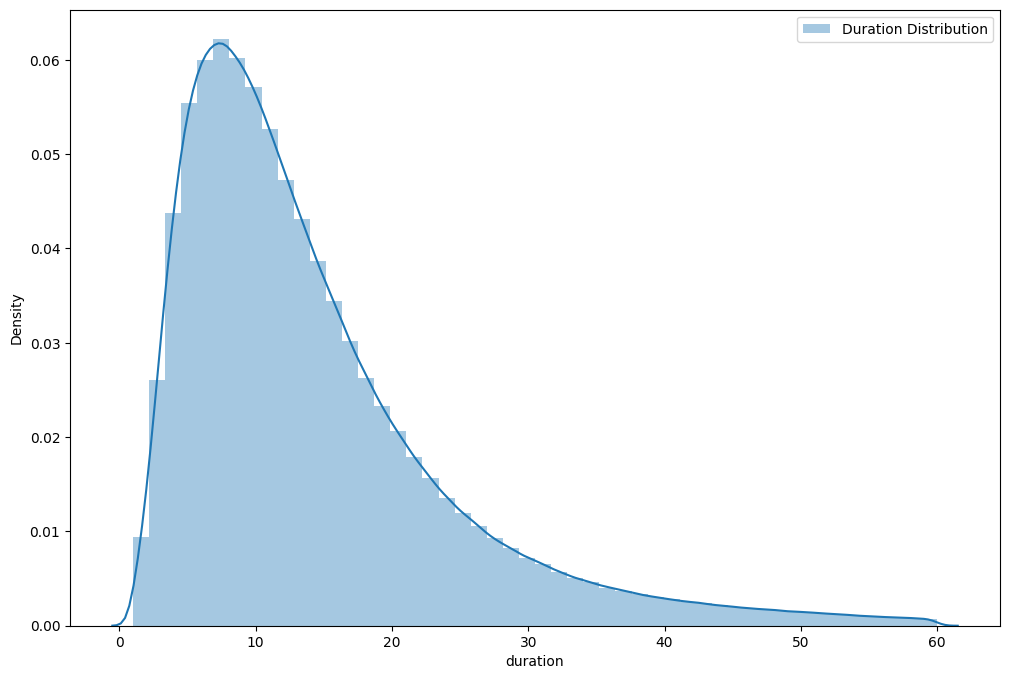

In [54]:
# Store the original number of records
original_count = len(df_one.duration)
print("Original data count: ", original_count)

# Filter the dataset to keep durations between 1 and 60 minutes
df_filtered = df_one[(df_one.duration >= 1) & (df_one.duration <= 60)]

# Store the new count after filtering
filtered_count = len(df_filtered)
print("Filtered data count: ", filtered_count)

# Calculate the fraction remaining
fraction_remaining = filtered_count / original_count

# Print the result
print(f"Fraction of records remaining after removing outliers: {fraction_remaining:.2%}")

# Plot the distribution of the filtered durations
plt.figure(figsize=(12, 8))
sns.distplot(df_filtered.duration, label='Duration Distribution')
plt.legend()

4. Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.
    - Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
    - Fit a dictionary vectorizer
    - Get a feature matrix from it
    - What's the dimensionality of this matrix (number of columns)?

In [55]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dict_vectorizer = DictVectorizer()
df_dicts = df_one[categorical + numerical].to_dict(orient="records")
X_train = dict_vectorizer.fit_transform(df_dicts)
print("The dimensionality of this matrix (number of columns): ", X_train.ndim)

The dimensionality of this matrix (number of columns):  2


5. Now let's use the feature matrix from the previous step to train a model.
    - Train a plain linear regression model with default parameters, where duration is the response variable
    - Calculate the RMSE of the model on the training data
    - What's the RMSE on train?

In [60]:
df = pd.read_parquet('./homework_data/yellow_tripdata_2023-01.parquet')

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.658559076531841

6. Evaluating the model
    - Now let's apply this model to the validation dataset (February 2023).
    - What's the RMSE on validation?

In [61]:
df = pd.read_parquet('./homework_data/yellow_tripdata_2023-02.parquet')

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.787924977339928